<center><img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="360" height="160" /></center>

# <center>CNN with Attention Mechanism</center>

## Table of Contents

1. [Seq2Seq Models using CNN with Attention Mechanism](#section1)<br><br>
2. [Machine Translation Data](#section2)<br><br>
3. [Preprocessing the Data](#section3)<br><br>
4. [Machine Translation Model with Attention Mechanism](#section4)
  - 4.1 [Encoder Model](#section401)<br><br>
  - 4.2 [Decoder Model](#section402)<br><br>
  - 4.3 [Fitting Model](#section403)<br><br>
  - 4.4 [Neural Machine Translation Inference](#section404)

<a id=section1></a>
## 1. Seq2Seq Models using CNN with Attention Mechanism

When we hear about **Convolutional Neural Network** (*CNNs*), we typically think of **Computer Vision**. 

CNNs were responsible for major breakthroughs in **Image Classification** and are the core of most Computer Vision systems today, from Facebook’s automated photo tagging to self-driving cars.

<br> 

---

<br> 
More recently we’ve also started to apply **CNNs** to problems in **Natural Language Processing** and gotten some interesting results.

We are going to build a **Seq2Seq** model using **CNNs** with **Attention Mechanism** for *Machine Translation*.

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attention.png"/></center>

We'll be using the following **process sequence** in this notebook:

<br> 
<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn0.png"/></center>

**Note:** The code used in this notebook is taken from the **official Keras tutorials**.

<a id=section2></a>
## 2. Machine Translation Data

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn1.png"/></center>

In [ ]:
# Checking whether GPU is available or not, to be used with tensorflow.
import tensorflow as tf 
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0': raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


The **dataset** used in the example involves short **Spanish and English sentence pairs** used in the flash card software Anki.

The dataset is called **“Tab-delimited Bilingual Sentence Pairs”** and is part of the **Tatoeba Project** and listed on the **ManyThings.org** site for helping English as a Second Language students.

In [ ]:
# Importing the dataset from github.
import urllib
response = urllib.request.urlopen('https://raw.githubusercontent.com/insaid2018/DeepLearning/master/Data/spa.txt')
lines = response.readlines()

text = []
for sent in lines:
    text.append(sent.decode('utf8'))
    
lines = text

In [ ]:
type(lines)

list

In [ ]:
# Checking a few samples from the dataset.
print(lines[0])
print(lines[1])
print(lines[2])

Go.	Ve.

Go.	Vete.

Go.	Vaya.



In [ ]:
# Checking the number of samples in the dataset.
len(lines)

123376

<a id=section3></a>
## 3. Preprocessing the Data

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn2.png"/></center>

In [ ]:
import numpy as np
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 128          # Batch size for training.
epochs = 100              # Number of epochs to train for.
num_samples = 10000       # Number of samples to train on.

- **Vectorizing** the **data**.

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

- Creating two list *input_texts* and *target_texts* containing **all** the **inputs** and **targets**.


- Creating two sets *input_characters* and *target_characters containing* the **unique characters** present in the **input** and the **target** respectively.

In [ ]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

- Converting the sets *input_characters* and *target_characters* into **lists** and **sorting** them.

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

- Creating variables *num_encoder_tokens* and *num_decoder_tokens* having value equal to the **number of unique values** present in the sets *input_characters* and *target_characters* respectively.

In [ ]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

- Creating variables *max_encoder_seq_length* and *max_decoder_seq_length* having values equal to the **length of longest sequences** present in the **input** and the **target** respectively.

In [ ]:
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 85
Max sequence length for inputs: 16
Max sequence length for outputs: 43


- Creating dictionaries *input_token_index* and *target_token_index* which have **unique characters** present in the *input* and the *target* as **keys** and their *position* as the **values** respectively.

In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [ ]:
input_token_index

{' ': 0,
 '!': 1,
 '$': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 ':': 17,
 '?': 18,
 'A': 19,
 'B': 20,
 'C': 21,
 'D': 22,
 'E': 23,
 'F': 24,
 'G': 25,
 'H': 26,
 'I': 27,
 'J': 28,
 'K': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'a': 43,
 'b': 44,
 'c': 45,
 'd': 46,
 'e': 47,
 'f': 48,
 'g': 49,
 'h': 50,
 'i': 51,
 'j': 52,
 'k': 53,
 'l': 54,
 'm': 55,
 'n': 56,
 'o': 57,
 'p': 58,
 'q': 59,
 'r': 60,
 's': 61,
 't': 62,
 'u': 63,
 'v': 64,
 'w': 65,
 'x': 66,
 'y': 67,
 'z': 68}

In [ ]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '"': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69,
 '¡': 70,
 '«': 71,
 '»': 72,
 '¿': 73,
 'Á': 74,
 'É': 75,
 'Ó': 76,
 'Ú': 77,
 'á': 78,
 'é': 79,
 'í': 80,
 'ñ': 81,
 'ó': 82,
 'ú': 83,
 'ü': 84}

- Creating 3 matrices containing only **zeroes**: *encoder_input_data*, *decoder_input_data*, *decoder_target_data*.


- The **shape** of each matrix is equal to *(len(input_texts), max_seq_length, num_tokens)*.


- *max_seq_length* and *num_tokens* have different values for **encoder** and **decoder**.

In [ ]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(10000, 16, 69)
(10000, 43, 85)
(10000, 43, 85)


- **Replacing** the **zeroes** in the above matrices with **1** based on whether a character is present at that location or not.


- This is similar to **one-hot-encoding** the features in 3 dimensions.

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [ ]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
decoder_input_data

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

<br>

The problem is framed as a **sequence prediction problem** where input sequences of characters are in **English** and output sequences of characters are in **Spanish**.

A total of **10,000** of the nearly **123,000** examples in the data file are **used** in the dataset. 

Some technical details of the prepared data are as follows:

 - **Input Sequences**: Padded to a **maximum length** of **16** characters with a **vocabulary** of **69** different characters **(10000, 16, 69)**.
 
 - **Output Sequences**: Padded to a **maximum length** of **43** characters with a **vocabulary** of **85** different characters **(10000, 43, 85)**.

<br> 

---

<br> 
The training data is framed such that the **input** for the model is comprised of *one whole input sequence of English characters* and the *whole output sequence of Spanish characters*. 

The **output** of the model is the *whole sequence of Spanish characters*, but *offset forward by one time step*.

For example (with minimal padding and without one-hot encoding):

Input1: [‘G’, ‘o’, ‘.’, ”] 

Input2: [ ”, ‘V’, ‘e’, ‘.‘]

Output: [‘V’, ‘e’, ‘.‘, ”]

<br> 

---

 Here’s a **summary** of our implementation:

1) Turn the sentences into 3 Numpy arrays: *encoder_input_data*, *decoder_input_data*, *decoder_target_data*.

 - *encoder_input_data* is a 3D array.  
   - Shape *(num_pairs, max_english_sentence_length, num_english_characters)*   
   - Containing a one-hot vectorization of the **English** sentences.
  
 - *decoder_input_data* is a 3D array. 
   - Shape *(num_pairs, max_spanish_sentence_length, num_spanish_characters)* 
   - Containing a one-hot vectorization of the **Spanish** sentences.
 
 - *decoder_target_data* is the same as *decoder_input_data* but **offset by one timestep**. 
   - *decoder_target_data[:, t, :]* will be the **same** as *decoder_input_data[:, t + 1, :]*<br/><br/>

2) An *encoder CNN* **encodes** the *input character sequence*.
<br><br>

3) A *decoder CNN* is **trained** to turn the *target sequences* into the *same sequence but offset by one timestep* in the future, a training process called "**teacher forcing**" in this context. 

  - It uses the **output** from the *encoder*. 
<br><br>
  - Effectively, the *decoder* learns to **generate** *targets[t+1...]* given *targets[...t]*, conditioned on the *input sequence*.

<a id=section4></a>
## 4. Machine Translation Model with Attention Mechanism

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn3.png"/></center>

<a id=section401></a>
### 4.1 Encoder Model

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn4.png"/></center>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dot, Dense, Activation, Concatenate

- Define an **input sequence** and process it.

In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))

- **Encoder**

In [ ]:
x_encoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal')(encoder_inputs)
x_encoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal', dilation_rate=2)(x_encoder)
x_encoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal', dilation_rate=4)(x_encoder)

<a id=section402></a>
### 4.2 Decoder Model

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn5.png"/></center>

In [ ]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))

- **Decoder**

In [ ]:
x_decoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal')(decoder_inputs)
x_decoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal', dilation_rate=2)(x_decoder)
x_decoder = Conv1D(256, kernel_size=3, activation='relu', padding='causal', dilation_rate=4)(x_decoder)

- **Attention**

In [ ]:
attention = Dot(axes=[2, 2])([x_decoder, x_encoder])
attention = Activation('softmax')(attention)

context = Dot(axes=[2, 1])([attention, x_encoder])
decoder_combined_context = Concatenate(axis=-1)([context, x_decoder])

In [ ]:
decoder_outputs = Conv1D(64, kernel_size=3, activation='relu', padding='causal')(decoder_combined_context)
decoder_outputs = Conv1D(64, kernel_size=3, activation='relu', padding='causal')(decoder_outputs)

- **Output**

In [ ]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

<a id=section403></a>
### 4.3 Fitting Model

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn6.png"/></center>

- Define the **model** that will turn `encoder_input_data` & `decoder_input_data` into `decoder_target_data`.

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 85)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None, 69)]   0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, None, 256)    65536       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 256)    53248       input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Fitting the model
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
          batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 8s 984us/sample - loss: 1.2735 - acc: 0.0802 - val_loss: 1.2130 - val_acc: 0.1252
Epoch 2/100
8000/8000 [==============================] - 3s 346us/sample - loss: 0.9584 - acc: 0.1240 - val_loss: 1.0460 - val_acc: 0.1611
Epoch 3/100
8000/8000 [==============================] - 3s 350us/sample - loss: 0.8340 - acc: 0.1550 - val_loss: 0.9353 - val_acc: 0.1881
Epoch 4/100
8000/8000 [==============================] - 3s 350us/sample - loss: 0.7466 - acc: 0.1793 - val_loss: 0.8589 - val_acc: 0.2106
Epoch 5/100
8000/8000 [==============================] - 3s 364us/sample - loss: 0.6922 - acc: 0.1943 - val_loss: 0.8325 - val_acc: 0.2177
Epoch 6/100
8000/8000 [==============================] - 3s 362us/sample - loss: 0.6564 - acc: 0.2037 - val_loss: 0.7959 - val_acc: 0.2283
Epoch 7/100
8000/8000 [==============================] - 3s 349us/sample - loss: 0.6240 - acc: 0.2132 - val_loss: 0.78

In [ ]:
print('Training Accuracy on last epoch =', model.history.history['acc'][-1])
print('Validation Accuracy on last epoch =', model.history.history['val_acc'][-1])
print('Peak Training Accuracy =', max(model.history.history['acc']))
print('Peak Validation Accuracy =', max(model.history.history['val_acc']))

Training Accuracy on last epoch = 0.38009304
Validation Accuracy on last epoch = 0.27423257
Peak Training Accuracy = 0.38089535
Peak Validation Accuracy = 0.27627906


In [ ]:
print('Training Loss on last epoch =', model.history.history['loss'][-1])
print('Validation Loss on last epoch =', model.history.history['val_loss'][-1])
print('Lowest Training Loss =', min(model.history.history['loss']))
print('Lowest Validation Loss =', min(model.history.history['val_loss']))

Training Loss on last epoch = 0.062993259370327
Validation Loss on last epoch = 1.4228821125030517
Lowest Training Loss = 0.060918811291456224
Lowest Validation Loss = 0.6810199298858642


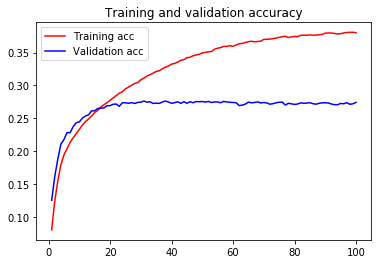

In [ ]:
# Plotting training and validation accuracy against epochs.
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
epochs_plot = range(1, len(acc) + 1)
plt.plot(epochs_plot, acc, 'r', label='Training acc')
plt.plot(epochs_plot, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

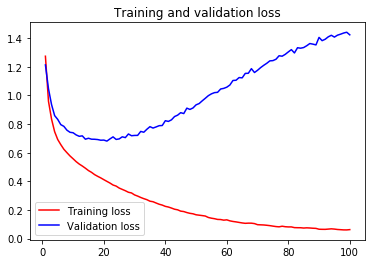

In [ ]:
# Plotting training and validation loss against epochs.
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(epochs_plot, loss, 'r', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

- Create a `weights` directory (folder) if not already present.

In [ ]:
!mkdir weights

- **Saving** the **model** in the `weights` directory.

In [ ]:
model.save('weights/cnn_s2s.h5')

<a id=section404></a>
### 4.4 Neural Machine Translation Inference

<center><img src="https://raw.githubusercontent.com/insaid2018/DeepLearning/master/images/cnn_attn7.png"/></center>

**Inference Models (Sampling)**

- In inference mode, when we want to **decode** unknown input sequences, we:
<br><br>  
  - **Encode** the input sequence.
<br><br>   
  - Start with a **target sequence** of size **1** (just the start-of-sequence character).
<br><br>  
  - Feed the **input sequence** and **1-char target** sequence to the *decoder* to produce predictions for the next character.
<br><br>   
  - **Sample** the next character using these predictions (we simply use **argmax**).
<br><br>   
  - **Append** the sampled character to the **target** sequence.
<br><br>   
  - **Repeat** until we hit the character **limit**.

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

- **Define Sampling Models**

In [ ]:
nb_examples = 100
in_encoder = encoder_input_data[:nb_examples]
in_decoder = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [ ]:
in_decoder[:, 0, target_token_index["\t"]] = 1

In [ ]:
predict = np.zeros((len(input_texts), max_decoder_seq_length), dtype='float32')

In [ ]:
for i in range(max_decoder_seq_length - 1):
    predict = model.predict([in_encoder, in_decoder])
    predict = predict.argmax(axis=-1)
    predict_ = predict[:, i].ravel().tolist()
    for j, x in enumerate(predict_):
        in_decoder[j, i + 1, x] = 1

- **Making Predictions**

In [ ]:
for seq_index in range(nb_examples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    output_seq = predict[seq_index, :].ravel().tolist()
    decoded = []
    for x in output_seq:
        if reverse_target_char_index[x] == "\n":
            break
        else:
            decoded.append(reverse_target_char_index[x])
    decoded_sentence = "".join(decoded)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Ve.
-
Input sentence: Go.
Decoded sentence: Ve.
-
Input sentence: Go.
Decoded sentence: Ve.
-
Input sentence: Go.
Decoded sentence: Ve.
-
Input sentence: Hi.
Decoded sentence: Hola.
-
Input sentence: Run!
Decoded sentence: ¡Corran!
-
Input sentence: Run!
Decoded sentence: ¡Corran!
-
Input sentence: Run!
Decoded sentence: ¡Corran!
-
Input sentence: Run!
Decoded sentence: ¡Corran!
-
Input sentence: Run.
Decoded sentence: Corred.
-
Input sentence: Who?
Decoded sentence: ¿Quién es ues?
-
Input sentence: Wow!
Decoded sentence: ¡Órale!
-
Input sentence: Fire!
Decoded sentence: ¡Fuego!
-
Input sentence: Fire!
Decoded sentence: ¡Fuego!
-
Input sentence: Fire!
Decoded sentence: ¡Fuego!
-
Input sentence: Help!
Decoded sentence: ¡Ahora por elso!
-
Input sentence: Help!
Decoded sentence: ¡Ahora por elso!
-
Input sentence: Help!
Decoded sentence: ¡Ahora por elso!
-
Input sentence: Jump!
Decoded sentence: ¡Sangod!
-
Input sentence: Jump.
Decoded sentence: Salt

- This shows some **great** results.

- We can also experiment with using a **word-level** model, instead of a **character-level** model, and compare the results.

- While using a **word-level** model, add an **Embedding layer** at the **top** of the *encoder* and the *decoder*.